In [145]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from numpy import random as nr
import theano as T
import theano.tensor as tt
from theano.compile.ops import as_op
#T.config.compute_test_value = "ignore"
#T.config.allow_input_downcast=True

%matplotlib inline

# gridworldclass that we made
from gridworldclass import gameEnv

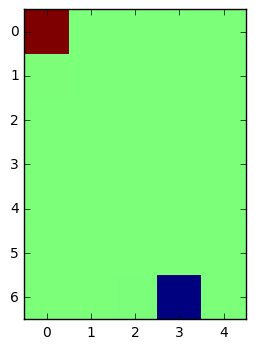

In [147]:
# build environment
wall_x = np.array([]);
wall_y = np.array([]);
wall_loc = np.array([wall_y, wall_x]).T
wall_states = np.zeros(wall_loc.shape[0])

#gameEnv(nrows,ncols,reward_loc, reward_mag,wall_loc, start_pos)
nrows = 7
ncols = 5
r_col = 0#np.random.randint(0,ncols,1)[0]
s_col = 3#np.random.randint(0,ncols,1)[0]
reward_loc = np.array([[0,r_col]])
reward_mag = np.array([1])
start_pos = np.array([nrows-1,s_col])
env = gameEnv(nrows,ncols,reward_loc, reward_mag,wall_loc, start_pos)

plt.close('all')
f,ax = plt.subplots(1)
env.render(ax)

# get lookahead matrix and reward
R = env.R
lookaheadmtx = env.lookaheadmtx
start_state = env.start_state

In [148]:
nruns = 100
nsamples = 1000
v_per_run = np.zeros([nruns,nsamples])


for run_num in np.arange(nruns):

    R = env.R
    R = np.append(R, 0)
    lookaheadmtx = env.lookaheadmtx
    nstates = env.nrows*env.ncols
    # add in a terminal state
    lookaheadmtx = np.vstack((lookaheadmtx, np.array([nstates,nstates,nstates,nstates])))
    max_step=200

    # inputs
    # vector to iterate over
    step_num = np.arange(max_step).astype('int64')
    # starting state
    S = step_num.dtype.type(env.start_state)
    # starting reward (do we need this?)
    r = step_num.dtype.type(0)
    #policy_vec = np.zeros(nstates+1).astype('int64')
    # one-step action->state transition matrix
    lookahead_mtx = lookaheadmtx.astype('int64')
    # reward vector
    r_vec = R.astype('int64')
    # terminal state
    T_state = step_num.dtype.type(nstates)
    # starting value for nsteps
    nsteps = step_num.dtype.type(max_step)

    T.config.compute_test_value = "ignore"

    # what happens on a step? - take in a state and a reward, produce a next state and a next reward
    def step(step_num,S,r,nsteps,policy_vec,lookahead_mtx,r_vec,T_state):
        #S = T.printing.Print('s')(S)
        a = policy_vec[S]
        r_new = r_vec[S]
        S_prime = tt.switch(r_new > 0, T_state, lookahead_mtx[S,a])
        nsteps  = tt.switch(r_new > 0, step_num, nsteps)
        return(S_prime,r_new,nsteps)

    #total_steps = output[2][-1]

    with pm.Model() as model_test:

        # make a policy vector
        policy_vec = pm.Categorical('policy_vec', p=np.array([.25, .25, .25, .25]), shape = nstates+1)
        p_print = tt.printing.Print('policy_vec')(policy_vec)

        output, updates = T.scan(fn=step,
                                  sequences=[step_num],
                                  outputs_info=[S,r,nsteps],
                                  non_sequences = [policy_vec,lookahead_mtx,r_vec,T_state])

        total_steps = output[2][-1]

        #total_steps = pm.Deterministic('total_steps',sim_episode(step_num_val,S_val,r_val,nsteps,policy_vec,lookahead_mtx,r_vec,T_state))

        V = pm.Deterministic('V', -1*total_steps)

        Q = pm.Deterministic('Q', tt.exp(V)/(tt.exp(0)))

        R = pm.Binomial('R',n=1,p = Q, observed = 1)

        step = pm.CategoricalGibbsMetropolis(vars=[policy_vec])
        #step = pm.Metropolis(vars = [policy_vec])
        trace = pm.sample(nsamples,step,tune=0)

    v_per_run[run_num,:] = trace[:]['V']

policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:41<00:00, 24.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.34it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 28.04it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 24.64it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.86it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:40<00:00, 24.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.87it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 21.98it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.89it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.77it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:41<00:00, 23.92it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:40<00:00, 24.55it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.06it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.63it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:41<00:00, 23.95it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 27.27it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.87it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.86it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.72it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.95it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:42<00:00, 23.60it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:41<00:00, 19.73it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 24.48it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.50it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.18it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 26.01it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:41<00:00, 24.17it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:40<00:00, 26.18it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 24.74it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:40<00:00, 26.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.93it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.03it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.59it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 27.34it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.89it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 25.82it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.97it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.27it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.47it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.56it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 27.03it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.76it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 25.77it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 25.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 25.98it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.12it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.41it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.53it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:39<00:00, 27.86it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.74it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 26.16it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:38<00:00, 27.32it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.74it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.71it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.73it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.64it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.14it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.08it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.96it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 26.11it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 25.95it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.93it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.90it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.93it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 25.76it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 27.31it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.12it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 24.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.41it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.67it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 26.29it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 25.18it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.90it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.29it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.32it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.21it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.91it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 25.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.05it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.56it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.56it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.71it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.94it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 27.87it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 26.58it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.54it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:36<00:00, 27.56it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:37<00:00, 26.67it/s]


In [113]:
plt.plot(np.mean(v_per_run,0))

In [126]:
nruns = 100
nsamples = 1000
v_per_run2 = np.zeros([nruns,nsamples])


for run_num in np.arange(nruns):

    R = env.R
    R = np.append(R, 0)
    lookaheadmtx = env.lookaheadmtx
    nstates = env.nrows*env.ncols
    # add in a terminal state
    lookaheadmtx = np.vstack((lookaheadmtx, np.array([nstates,nstates,nstates,nstates])))
    max_step=200

    # inputs
    # vector to iterate over
    step_num = np.arange(max_step).astype('int64')
    # starting state
    S = step_num.dtype.type(env.start_state)
    # starting reward (do we need this?)
    r = step_num.dtype.type(0)
    #policy_vec = np.zeros(nstates+1).astype('int64')
    # one-step action->state transition matrix
    lookahead_mtx = lookaheadmtx.astype('int64')
    # reward vector
    r_vec = R.astype('int64')
    # terminal state
    T_state = step_num.dtype.type(nstates)
    # starting value for nsteps
    nsteps = step_num.dtype.type(max_step)

    T.config.compute_test_value = "ignore"

    # what happens on a step? - take in a state and a reward, produce a next state and a next reward
    def step(step_num,S,r,nsteps,policy_vec,lookahead_mtx,r_vec,T_state):
        #S = T.printing.Print('s')(S)
        a = policy_vec[S]
        r_new = r_vec[S]
        S_prime = tt.switch(r_new > 0, T_state, lookahead_mtx[S,a])
        nsteps  = tt.switch(r_new > 0, step_num, nsteps)
        return(S_prime,r_new,nsteps)

    #total_steps = output[2][-1]

    with pm.Model() as model_test:

        # make a policy vector
        policy_vec = pm.Categorical('policy_vec', p=np.array([.7, .1, .1, .1]), shape = nstates+1)
        p_print = tt.printing.Print('policy_vec')(policy_vec)

        output, updates = T.scan(fn=step,
                                  sequences=[step_num],
                                  outputs_info=[S,r,nsteps],
                                  non_sequences = [policy_vec,lookahead_mtx,r_vec,T_state])

        total_steps = output[2][-1]

        #total_steps = pm.Deterministic('total_steps',sim_episode(step_num_val,S_val,r_val,nsteps,policy_vec,lookahead_mtx,r_vec,T_state))

        V = pm.Deterministic('V', -1*total_steps)

        Q = pm.Deterministic('Q', tt.exp(V)/(tt.exp(0)))

        R = pm.Binomial('R',n=1,p = Q, observed = 1)

        step = pm.CategoricalGibbsMetropolis(vars=[policy_vec])
        #step = pm.Metropolis(vars = [policy_vec])
        trace = pm.sample(nsamples,step,tune=0)

    v_per_run2[run_num,:] = trace[:]['V']

policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.09it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.89it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 27.97it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.45it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.58it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.37it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.46it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.90it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.31it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.95it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.59it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.81it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.10it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.67it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.61it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.01it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.07it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.57it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.19it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.09it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.60it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.64it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.23it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.86it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.29it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.40it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.22it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.00it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.46it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.57it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.08it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.15it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.96it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.29it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.41it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.12it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.76it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.70it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.02it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.65it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.94it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.57it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.66it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.74it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.05it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.08it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.63it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.64it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.21it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.03it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.81it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.87it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.24it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.31it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.33it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.93it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.67it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.83it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.73it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.80it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:35<00:00, 28.63it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.03it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.33it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.84it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.10it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.50it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.96it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.89it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.66it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.97it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 29.43it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.89it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.39it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.48it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:33<00:00, 30.25it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.97it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.87it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 28.74it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.09it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.11it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 1000/1000 [00:34<00:00, 29.16it/s]


In [121]:
plt.close('all')
plt.plot(np.mean(v_per_run,0))
plt.plot(np.mean(v_per_run2,0))

In [125]:
nruns = 100
nsamples = 1000
v_per_run3 = np.zeros([nruns,nsamples])


for run_num in np.arange(nruns):

    R = env.R
    R = np.append(R, 0)
    lookaheadmtx = env.lookaheadmtx
    nstates = env.nrows*env.ncols
    # add in a terminal state
    lookaheadmtx = np.vstack((lookaheadmtx, np.array([nstates,nstates,nstates,nstates])))
    max_step=200

    # inputs
    # vector to iterate over
    step_num = np.arange(max_step).astype('int64')
    # starting state
    S = step_num.dtype.type(env.start_state)
    # starting reward (do we need this?)
    r = step_num.dtype.type(0)
    #policy_vec = np.zeros(nstates+1).astype('int64')
    # one-step action->state transition matrix
    lookahead_mtx = lookaheadmtx.astype('int64')
    # reward vector
    r_vec = R.astype('int64')
    # terminal state
    T_state = step_num.dtype.type(nstates)
    # starting value for nsteps
    nsteps = step_num.dtype.type(max_step)

    T.config.compute_test_value = "ignore"

    # what happens on a step? - take in a state and a reward, produce a next state and a next reward
    def step(step_num,S,r,nsteps,policy_vec,lookahead_mtx,r_vec,T_state):
        #S = T.printing.Print('s')(S)
        a = policy_vec[S]
        r_new = r_vec[S]
        S_prime = tt.switch(r_new > 0, T_state, lookahead_mtx[S,a])
        nsteps  = tt.switch(r_new > 0, step_num, nsteps)
        return(S_prime,r_new,nsteps)

    #total_steps = output[2][-1]

    with pm.Model() as model_test:
        
        alpha = np.array([1, 1, 1, 1],dtype = np.int64)    
        
        theta = pm.Dirichlet('theta', alpha)
        
        # make a policy vector
        policy_vec = pm.Categorical('policy_vec', p=theta, shape = nstates+1)
        p_print = tt.printing.Print('policy_vec')(policy_vec)

        output, updates = T.scan(fn=step,
                                  sequences=[step_num],
                                  outputs_info=[S,r,nsteps],
                                  non_sequences = [policy_vec,lookahead_mtx,r_vec,T_state])

        total_steps = output[2][-1]

        #total_steps = pm.Deterministic('total_steps',sim_episode(step_num_val,S_val,r_val,nsteps,policy_vec,lookahead_mtx,r_vec,T_state))

        V = pm.Deterministic('V', -1*total_steps)

        Q = pm.Deterministic('Q', tt.exp(V)/(tt.exp(0)))

        R = pm.Binomial('R',n=1,p = Q, observed = 1)

        step = pm.CategoricalGibbsMetropolis(vars=[policy_vec])
        #step = pm.Metropolis(vars = [policy_vec])
        trace = pm.sample(nsamples,step,tune=0)

    v_per_run3[run_num,:] = trace[:]['V']

policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 21.36it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0676453332498, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 17 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:45<00:00, 22.93it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.073061820205, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 27 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 21.95it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0700773192163, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 34 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:49<00:00, 22.26it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0597001802788, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:49<00:00, 20.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:45<00:00, 21.97it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0618594200658, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 18 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:44<00:00, 21.79it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.05595243608, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 24 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:44<00:00, 22.44it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:46<00:00, 21.45it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0458072578995, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 12 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:46<00:00, 21.37it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:50<00:00, 21.37it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0616530377985, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 37 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:50<00:00, 19.73it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:49<00:00, 20.58it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0530992364501, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 23 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:49<00:00, 20.30it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:49<00:00, 20.65it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0552061637193, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 35 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:49<00:00, 20.38it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0636469408023, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 21 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:49<00:00, 20.07it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 22.21it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.06310506784, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 33 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:45<00:00, 22.84it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0566565968855, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 29 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 21.96it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:44<00:00, 21.77it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0566223542211, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 28 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:44<00:00, 22.36it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:51<00:00, 21.53it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.06519775912, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:46<00:00, 22.43it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0535643351252, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 49 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:47<00:00, 21.27it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0659339086379, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:47<00:00, 21.92it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0548567723547, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 26 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:43<00:00, 24.08it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0638136661244, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:45<00:00, 21.85it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.063695462209, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 22 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 22.13it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:51<00:00, 20.96it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0549328353349, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 31 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:45<00:00, 21.24it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0701125553723, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:45<00:00, 21.77it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 18.94it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.06822678035, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:47<00:00, 20.94it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 22.19it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0622896317327, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 52 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:52<00:00, 19.76it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0628782381688, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:52<00:00, 19.14it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:47<00:00, 21.20it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0608785888325, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:47<00:00, 21.13it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0705653166884, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 40 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.07it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 22.50it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0592273049531, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 22.04it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0519672250036, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:52<00:00, 19.80it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0639059270439, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:58<00:00, 20.98it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.115908468651, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 20 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:58<00:00, 17.02it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:54<00:00, 17.41it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0571622541496, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:51<00:00, 19.53it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0493506425141, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:51<00:00, 19.48it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:48<00:00, 21.29it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0681895445739, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:48<00:00, 20.54it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:48<00:00, 21.23it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0573068222269, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:48<00:00, 20.75it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:49<00:00, 20.70it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0594701120545, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:49<00:00, 20.31it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0738420461579, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 11 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:50<00:00, 17.30it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0630109085413, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:47<00:00, 22.78it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0705310337319, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:46<00:00, 21.35it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.066019295532, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 36 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:46<00:00, 21.64it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 22.15it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0630258974347, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 13 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:49<00:00, 17.84it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0567125524177, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 20.74it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0672532050702, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 25 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.11it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0564593436495, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 39 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 22.43it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0692234806384, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:48<00:00, 20.97it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0625093822269, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:44<00:00, 23.61it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0551497515129, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:45<00:00, 22.21it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:42<00:00, 22.61it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0544131652346, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:40<00:00, 24.76it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0535040573308, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 21.43it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0711082551222, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 19 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:46<00:00, 22.01it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0575552176945, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 16 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:46<00:00, 21.32it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:46<00:00, 20.88it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0627365039324, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:46<00:00, 21.38it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:45<00:00, 21.57it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0625429820739, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 21.41it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0707592154385, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:47<00:00, 21.10it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0574478247739, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:47<00:00, 21.22it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:47<00:00, 20.66it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0679648806542, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 14 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 21.27it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0651317160448, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:46<00:00, 20.75it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0496361062037, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:46<00:00, 21.55it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:49<00:00, 19.16it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0525940251815, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:47<00:00, 22.04it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0725552514697, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:47<00:00, 21.72it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.066050352686, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 21.70it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0536272170447, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:45<00:00, 22.50it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.06363946727, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 18.58it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0566405261508, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:46<00:00, 22.76it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0596207353341, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:46<00:00, 21.67it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:43<00:00, 23.19it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0610217785787, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:43<00:00, 23.13it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 23.66it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0635471482482, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:46<00:00, 22.22it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0529649061443, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:46<00:00, 21.68it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:45<00:00, 20.27it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0749394806296, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:45<00:00, 22.05it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:48<00:00, 21.09it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.078603656518, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 15 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:46<00:00, 19.33it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0627798767827, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:52<00:00, 18.85it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0727303620594, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:52<00:00, 19.08it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:52<00:00, 20.56it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0639860810754, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:52<00:00, 18.96it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:49<00:00, 22.39it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0632041350237, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:49<00:00, 20.17it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:45<00:00, 22.96it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0726953262841, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 21.98it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 998/1000 [00:45<00:00, 20.02it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0662489794034, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 32 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:44<00:00, 23.98it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0633724562379, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 10 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|█████████▉| 999/1000 [00:41<00:00, 24.77it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0785645847576, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]


policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.38it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0653351096432, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.19it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0583003900031, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.42it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0751338603178, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 46 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.13it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0630571571084, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 30 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.37it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0663572472671, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.36it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0625608231766, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.86it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0654151465366, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0698014304183, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.10it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0759907194118, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.33it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0658008812819, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.47it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0635281709474, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:42<00:00, 23.68it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0733018939279, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0655987549419, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.82it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0517446046597, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.57it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.067432875047, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.20it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0622308656235, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.87it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0532876937654, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.59it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0645026698317, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.74it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0728065766365, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.21it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0623006446637, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 23.53it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0532148267495, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0721247510581, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [139]:
nruns = 1
nsamples = 1000
v_per_run4 = np.zeros([nruns,nsamples])


for run_num in np.arange(nruns):

    R = env.R
    R = np.append(R, 0)
    lookaheadmtx = env.lookaheadmtx
    nstates = env.nrows*env.ncols
    # add in a terminal state
    lookaheadmtx = np.vstack((lookaheadmtx, np.array([nstates,nstates,nstates,nstates])))
    max_step=200

    # inputs
    # vector to iterate over
    step_num = np.arange(max_step).astype('int64')
    # starting state
    S = step_num.dtype.type(env.start_state)
    # starting reward (do we need this?)
    r = step_num.dtype.type(0)
    #policy_vec = np.zeros(nstates+1).astype('int64')
    # one-step action->state transition matrix
    lookahead_mtx = lookaheadmtx.astype('int64')
    # reward vector
    r_vec = R.astype('int64')
    # terminal state
    T_state = step_num.dtype.type(nstates)
    # starting value for nsteps
    nsteps = step_num.dtype.type(max_step)

    T.config.compute_test_value = "ignore"

    # what happens on a step? - take in a state and a reward, produce a next state and a next reward
    def step(step_num,S,r,nsteps,policy_vec,lookahead_mtx,r_vec,T_state):
        #S = T.printing.Print('s')(S)
        a = policy_vec[S]
        r_new = r_vec[S]
        S_prime = tt.switch(r_new > 0, T_state, lookahead_mtx[S,a])
        nsteps  = tt.switch(r_new > 0, step_num, nsteps)
        return(S_prime,r_new,nsteps)

    #total_steps = output[2][-1]

    with pm.Model() as model_test:
        
        alpha = np.array([1, 1, 1, 1],dtype = np.int64)    
        
        theta = pm.Dirichlet('theta', alpha)
        
        # make a policy vector
        policy_vec = pm.Categorical('policy_vec', p=theta, shape = nstates+1)
        p_print = tt.printing.Print('policy_vec')(policy_vec)

        output, updates = T.scan(fn=step,
                                  sequences=[step_num],
                                  outputs_info=[S,r,nsteps],
                                  non_sequences = [policy_vec,lookahead_mtx,r_vec,T_state])

        total_steps = output[2][-1]

        #total_steps = pm.Deterministic('total_steps',sim_episode(step_num_val,S_val,r_val,nsteps,policy_vec,lookahead_mtx,r_vec,T_state))

        V = pm.Deterministic('V', -1*total_steps)

        Q = pm.Deterministic('Q', tt.exp(V)/(tt.exp(0)))

        R = pm.Binomial('R',n=1,p = Q, observed = 1)

        step = pm.CategoricalGibbsMetropolis(vars=[policy_vec])
        #step = pm.Metropolis(vars = [policy_vec])
        trace = pm.sample(nsamples,step,tune=0)

    v_per_run4[run_num,:] = trace[:]['V']

policy_vec __str__ = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Assigned NUTS to theta_stickbreaking__
100%|██████████| 1000/1000 [00:42<00:00, 22.95it/s]/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.0590703805253, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/evanrussek/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 47 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



In [140]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x248f0deb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2531937b8>]], dtype=object)

In [142]:
trace['theta']

array([[ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
       [ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
       [ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
       ..., 
       [ 0.57290945,  0.12598531,  0.2397653 ,  0.06133994],
       [ 0.7388543 ,  0.01508429,  0.21742893,  0.02863248],
       [ 0.7388543 ,  0.01508429,  0.21742893,  0.02863248]])

In [132]:
plt.plot(np.mean(v_per_run,0),color = 'b')
plt.plot(np.mean(v_per_run2,0), color = 'r')
plt.plot(np.mean(v_per_run3,0), color = 'g')

In [78]:
def sim_episode(env, policy_vec, max_step, show, ax):

    d = False
    j = 0
    S = env.reset()

    while j < max_step:
        
        if show == 1:
            # draw environment and pause
            env.render(ax)
            plt.pause(.1)
            
        # increase counter
        j += 1
        
        # sample action given by pi for state S
        a = policy_vec[S]
        
        # take action A, observe s1, r, terminal?
        S_prime,r,d = env.step(a)

        # update S
        S = S_prime;
            
        if d == True:
            break
            
    return j

In [80]:
%matplotlib qt 
plt.close('all')
f,ax = plt.subplots(1)
sim_episode(env,trace[0]['policy_vec'],200,1,ax)

/Users/evanrussek/anaconda/lib/python3.5/site-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


10

In [18]:
%matplotlib qt 
f,ax = plt.subplots(1)
